In [33]:
from shapely.geometry import Point, LineString
import geopandas as gpd
import numpy as np
from src.utils import RoadState, RoadLevel
import uuid
import pandas as pd
from numba import jit

In [34]:
attrs = ['geometry', 'level', 'state', 'uid']
# 指定列名创建空的 DataFrame
gdf = gpd.GeoDataFrame(columns=attrs)
gdf.set_index('uid')

,geometry,level,state
uid,,,


In [35]:
def add_road(points: np.ndarray, level: RoadLevel, state: RoadState):
    global gdf
    if len(points) < 2:
        geometry = Point(points)
    else:
        geometry = LineString(points)
    uid = uuid.uuid4()
    new_row = {'geometry': [geometry], 'level': [level], 'state': [state], 'uid': [uid]}
    new_gdf = gpd.GeoDataFrame(new_row, index=new_row['uid'])
    gdf = gpd.pd.concat([gdf, new_gdf], ignore_index=False)
    return uid

In [36]:
uid1 = add_road(np.array([[0, 0]]), RoadLevel.MAIN, RoadState.RAW)
uid2 = add_road(np.array([[1, 1]]), RoadLevel.SECONDARY, RoadState.OPTIMIZING)

In [37]:
gdf

,geometry,level,state,uid
14ac7a94-f993-4fa2-9d6f-8262e603dac9,POINT (0.00000 0.00000),RoadLevel.MAIN,RoadState.RAW,14ac7a94-f993-4fa2-9d6f-8262e603dac9
f584ac29-cb7e-4e83-a282-5fff48ebbacb,POINT (1.00000 1.00000),RoadLevel.SECONDARY,RoadState.OPTIMIZING,f584ac29-cb7e-4e83-a282-5fff48ebbacb


In [38]:
road = gdf.loc[uid2]
road

geometry                             POINT (1 1)
level                        RoadLevel.SECONDARY
state                       RoadState.OPTIMIZING
uid         f584ac29-cb7e-4e83-a282-5fff48ebbacb
Name: f584ac29-cb7e-4e83-a282-5fff48ebbacb, dtype: object

In [39]:
geo = road['geometry']


In [40]:
points = np.array(list(geo.coords))


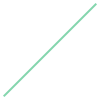

In [41]:
new_point = np.array([[2,2]])
new_points = np.vstack([points, new_point])
new_geo = LineString(new_points)
new_geo

In [42]:
gdf.at[road['uid'], 'geometry'] = new_geo
gdf

,geometry,level,state,uid
14ac7a94-f993-4fa2-9d6f-8262e603dac9,POINT (0.00000 0.00000),RoadLevel.MAIN,RoadState.RAW,14ac7a94-f993-4fa2-9d6f-8262e603dac9
f584ac29-cb7e-4e83-a282-5fff48ebbacb,"LINESTRING (1.00000 1.00000, 2.00000 2.00000)",RoadLevel.SECONDARY,RoadState.OPTIMIZING,f584ac29-cb7e-4e83-a282-5fff48ebbacb


<Axes: >

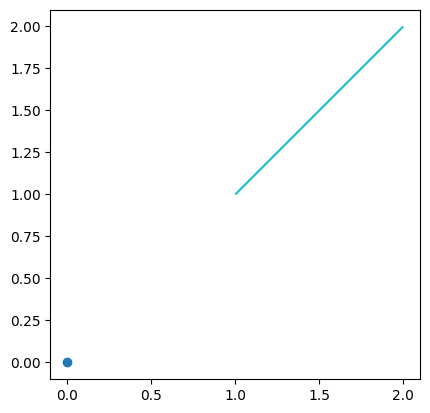

In [43]:
gdf.plot(column='level')

In [44]:
road = gdf.loc[uid2]
road

geometry                   LINESTRING (1 1, 2 2)
level                        RoadLevel.SECONDARY
state                       RoadState.OPTIMIZING
uid         f584ac29-cb7e-4e83-a282-5fff48ebbacb
Name: f584ac29-cb7e-4e83-a282-5fff48ebbacb, dtype: object

In [45]:
from shapely.ops import split

In [46]:
geo = road['geometry']
uid = road['uid']
state = road['state']
level = road['level']

if not isinstance(geo, LineString):
    raise Exception('error')
cut_point = geo.interpolate(0.3, True)
result = list(split(geo, cut_point).geoms)
assert len(result) == 2
result

[<LINESTRING (1 1, 1.3 1.3)>, <LINESTRING (1.3 1.3, 2 2)>]

In [48]:
road = gdf.loc[uid1]
road

geometry                             POINT (0 0)
level                             RoadLevel.MAIN
state                              RoadState.RAW
uid         14ac7a94-f993-4fa2-9d6f-8262e603dac9
Name: 14ac7a94-f993-4fa2-9d6f-8262e603dac9, dtype: object

In [50]:
pts = np.array(list(road['geometry'].coords))
pts.shape

(1, 2)

In [74]:

start_points = np.array(gdf['geometry'].apply(lambda geom: geom.coords[0]).tolist())
end_points = np.array(gdf['geometry'].apply(lambda geom: geom.coords[-1]).tolist())
all_points = np.vstack([start_points, end_points])
all_points


array([[0., 0.],
       [1., 1.],
       [0., 0.],
       [2., 2.]])

In [82]:
unique_points, new2old, old2new = np.unique(all_points, axis=0, return_index=True, return_inverse=True)
unique_points

array([[0., 0.],
       [1., 1.],
       [2., 2.]])

In [83]:
old2new

array([0, 1, 0, 2], dtype=int64)

In [84]:
new2old

array([0, 1, 3], dtype=int64)

In [127]:
gdf = gdf.drop(gdf['uid'])
gdf

,geometry,level,state,uid


In [88]:
import networkx as nx
import pandas as pd

# 假设 G 是一个 NetworkX 图
G = nx.Graph()

# 添加节点和节点属性
G.add_node('A', x=0, y=0, geometry='Point A')
G.add_node('B', x=1, y=1, geometry='Point B')
G.add_node('C', x=2, y=2, geometry='Point C')

for uid, data in G.nodes.data():
    print(uid, data)

A {'x': 0, 'y': 0, 'geometry': 'Point A'}
B {'x': 1, 'y': 1, 'geometry': 'Point B'}
C {'x': 2, 'y': 2, 'geometry': 'Point C'}
